In [35]:
from numpy import log
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from scipy.stats import norm, expon, lognorm
from seaborn import distplot, heatmap
from libs.ds_charts import bar_chart, get_variable_types, choose_grid, HEIGHT, multiple_bar_chart, multiple_line_chart

In [36]:
pd.plotting.register_matplotlib_converters()

filename = 'dataset_1/NYC_collisions_tabular.csv'
data = pd.read_csv(filename, na_values='na')

data.shape

(45669, 21)

# Data Dimensionality

Number of records vs number of variables

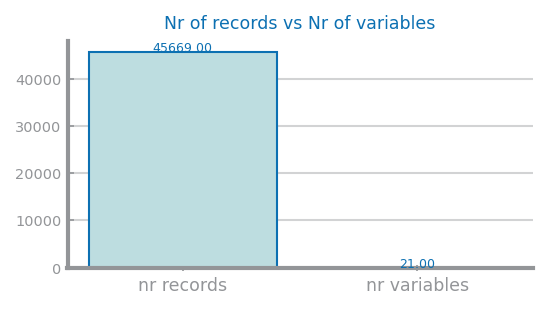

In [37]:
plt.figure(figsize=(4,2))
values = {'nr records': data.shape[0], 'nr variables': data.shape[1]}
bar_chart(list(values.keys()), list(values.values()), title='Nr of records vs Nr of variables')
plt.savefig('dataset_1/profiling/dimensionality/records_vs_variables_ds1.png')

Number of variables per type

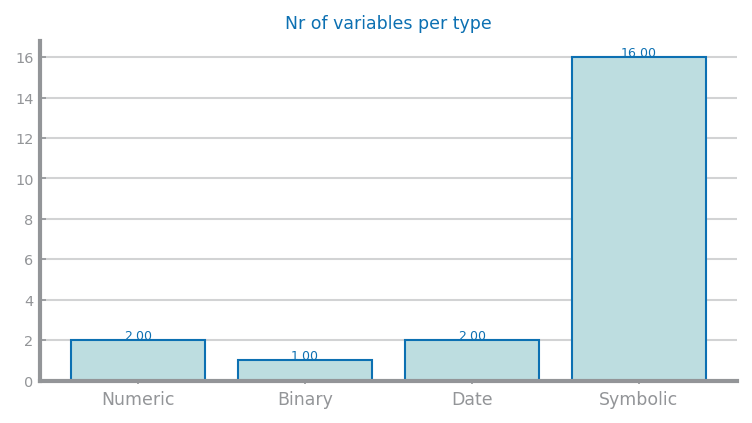

In [38]:
cat_vars = data.select_dtypes(include='object')
data[cat_vars.columns] = data.select_dtypes(['object']).apply(lambda x: x.astype('category'))
def get_variable_types(df: pd.DataFrame) -> dict:
    variable_types: dict = {
        'Numeric': [],
        'Binary': [],
        'Date': [],
        'Symbolic': []
    }
    for c in df.columns:
        uniques = df[c].dropna(inplace=False).unique()
        if len(uniques) == 2:
            variable_types['Binary'].append(c)
            df[c].astype('bool')
        elif df[c].dtype == 'datetime64':
            variable_types['Date'].append(c)
        elif c == "CRASH_DATE":
            variable_types['Date'].append(c)
        elif c == "CRASH_TIME":
            variable_types['Date'].append(c)
        elif df[c].dtype == 'int':
            variable_types['Numeric'].append(c)
        elif df[c].dtype == 'float':
            variable_types['Numeric'].append(c)
        else:
            df[c].astype('category')
            variable_types['Symbolic'].append(c)

    return variable_types

variable_types = get_variable_types(data)
counts = {}
for tp in variable_types.keys():
    counts[tp] = len(variable_types[tp])
plt.figure(figsize=(6,3))
bar_chart(list(counts.keys()), list(counts.values()), title='Nr of variables per type')
plt.savefig('dataset_1/profiling/dimensionality/variables_per_type_ds1.png')

Number of missing variables per variable

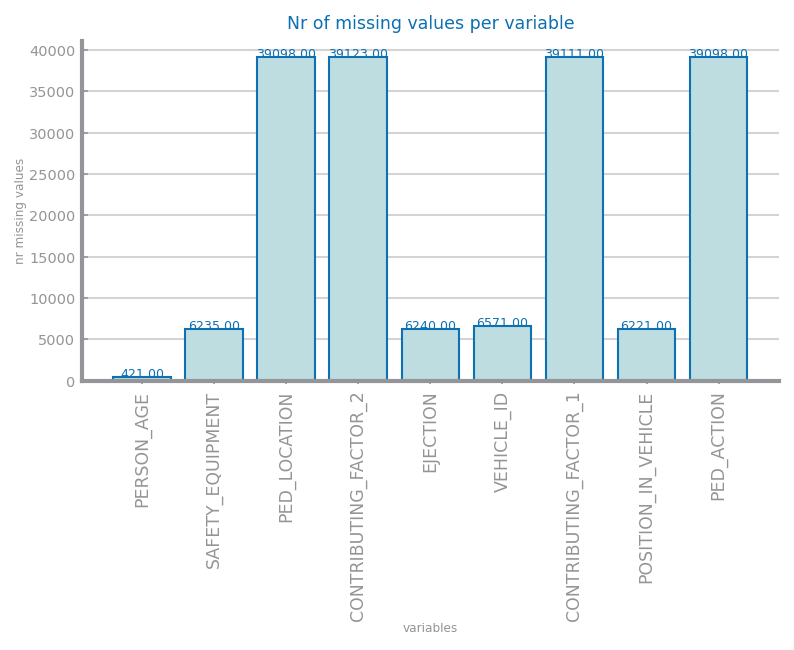

In [39]:
mv = {}
for var in data:
    nr = data[var].isna().sum()
    if nr > 0:
        mv[var] = nr

plt.figure(figsize=(6,3))

bar_chart(list(mv.keys()), list(mv.values()), title='Nr of missing values per variable',
            xlabel='variables', ylabel='nr missing values', rotation=True)
plt.savefig('dataset_1/profiling/dimensionality/missing_values_ds1.png',bbox_inches="tight")
plt.show()

# Data Granularity

Numeric variables

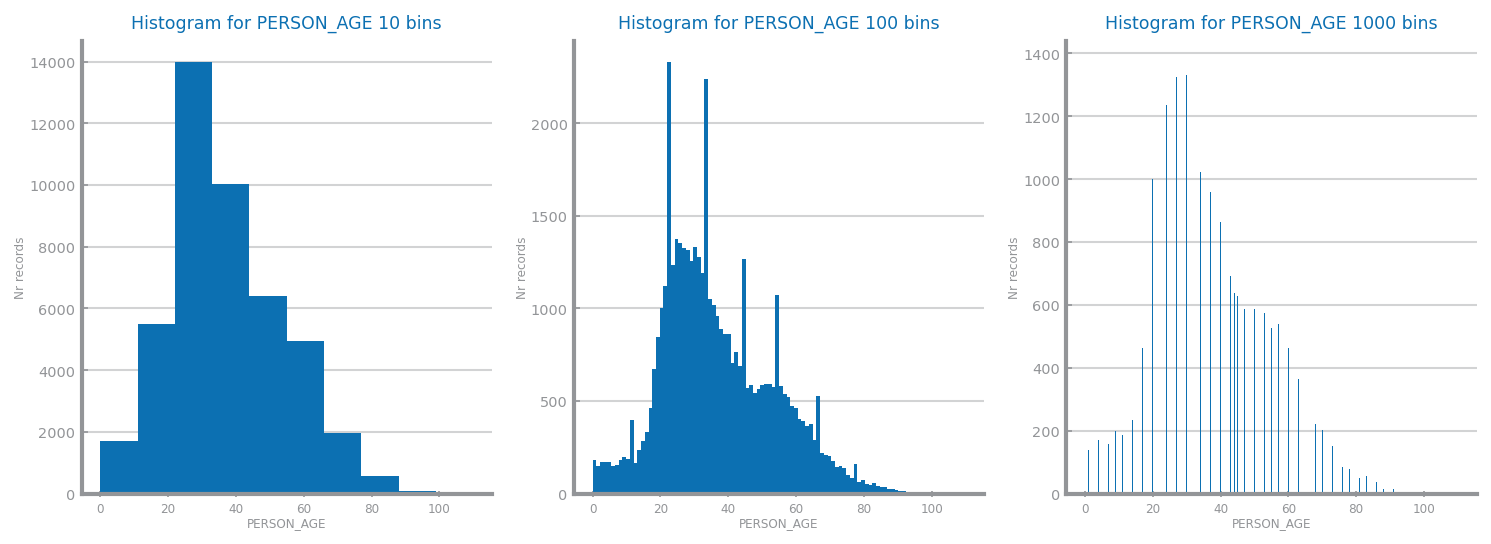

In [40]:
numeric_vars = ['PERSON_AGE']
if [] == numeric_vars:
    raise ValueError('There are no numeric variables.')
    
rows = len(numeric_vars)
bins = (10, 100, 1000)
cols = len(bins)
fig, axs = plt.subplots(rows, cols, figsize=(cols*HEIGHT, rows*HEIGHT), squeeze=False)
for i in range(rows):
    for j in range(cols):
        axs[i, j].set_title('Histogram for %s %d bins'%(numeric_vars[i], bins[j]))
        axs[i, j].set_xlabel(numeric_vars[i])
        axs[i, j].set_ylabel('Nr records')
        axs[i, j].hist(data[numeric_vars[i]].values, bins=bins[j], range=(0,110))
plt.savefig('dataset_1/profiling/granularity/granularity_study_numeric_variables_ds1.png')
plt.show()

Symbolic variables

##### BODY_INJURY
	Entire Body:
		Upper Body:
			Head
			Face
			Neck
			Shoulder 
			Arm
			Hand
			Back
			Elbow
		Lower Body:
			Leg
			Knee
			Foot


##### COMPLAINT
	None Visible
	Light:
		Pain or Nausea
		Minor Bleeding
	Medium:
		Fracture
		Contusion - Bruise
	Dangerous:
		Severe Bleeding
		Internal
		Severe Lacerations
		Whiplash


##### CRASH_DATE
	Winter:
		21/Dec - 20/Mar
	Summer:
		21/Jun - 23/Sep
	Autumn:
		22/Sep - 21/Dec
	Spring:
		20/Mar - 21/Jun

##### CRASH_DATE
	Quarter:
		Month:
			Weekday:
				Day of month

##### CRASH_HOUR
	Day:
		07h-19h
	Night:
		20h-06h

##### PERSON_AGE
	Children
	Young Adults
	Adults
	Seniors
	Elderly


# Data Distribution

In [41]:
summary5 = data.describe()
summary5

PERSON_AGE    VEHICLE_ID     UNIQUE_ID  COLLISION_ID
count  45248.000000  3.909800e+04  4.566900e+04  4.566900e+04
mean      37.487646  1.999663e+07  1.183588e+07  4.431737e+06
std       81.492032  7.940981e+04  1.375828e+05  2.753403e+04
min     -971.000000  1.982197e+07  1.153725e+07  4.380715e+06
25%       25.000000  1.996078e+07  1.177289e+07  4.408781e+06
50%       34.000000  2.000877e+07  1.185680e+07  4.432358e+06
75%       48.000000  2.005868e+07  1.194421e+07  4.455395e+06
max     9999.000000  2.010992e+07  1.203146e+07  4.478832e+06

Single boxplot for age

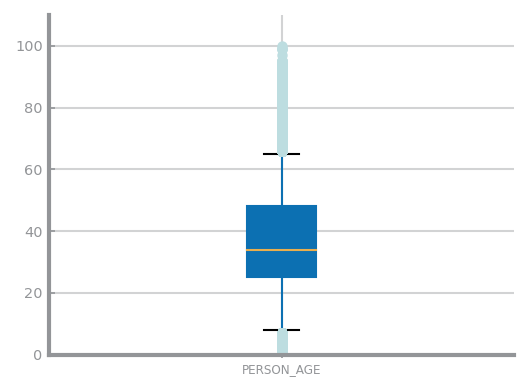

In [42]:
ax = data.boxplot(column=['PERSON_AGE'],return_type='axes')
ax.set_ylim(0, 110)
plt.savefig('dataset_1/profiling/distribution/age_boxplot_ds1.png')

Number of outliers for age

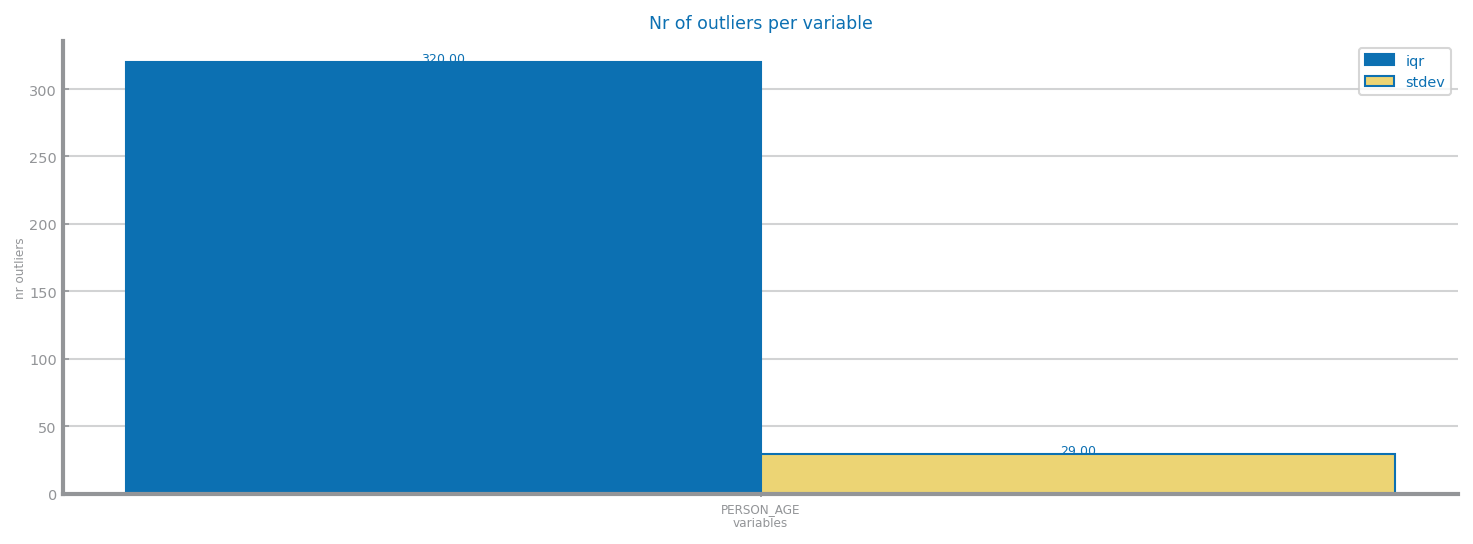

In [43]:
NR_STDEV: int = 2

if [] == numeric_vars:
    raise ValueError('There are no numeric variables.')

outliers_iqr = []
outliers_stdev = []
summary5 = data.describe(include='number')

for var in numeric_vars:
    iqr = 1.5 * (summary5[var]['75%'] - summary5[var]['25%'])
    outliers_iqr += [
        data[data[var] > summary5[var]['75%']  + iqr].count()[var] +
        data[data[var] < summary5[var]['25%']  - iqr].count()[var]]
    std = NR_STDEV * summary5[var]['std']
    outliers_stdev += [
        data[data[var] > summary5[var]['mean'] + std].count()[var] +
        data[data[var] < summary5[var]['mean'] - std].count()[var]]

outliers = {'iqr': outliers_iqr, 'stdev': outliers_stdev}
plt.figure(figsize=(12, HEIGHT))
multiple_bar_chart(numeric_vars, outliers, title='Nr of outliers per variable', xlabel='variables', ylabel='nr outliers', percentage=False)
plt.savefig('dataset_1/profiling/distribution/outliers_ds1.png')

Number of records per value

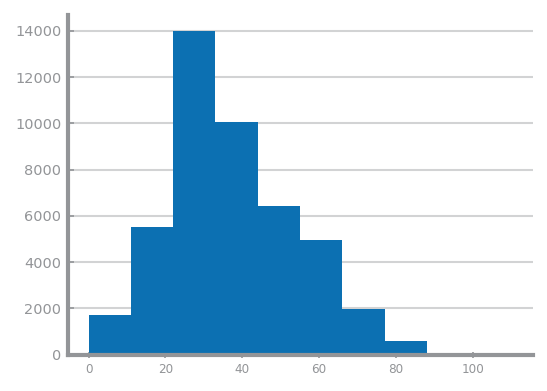

In [44]:
# Number of records per value
plt.hist(data['PERSON_AGE'].dropna().values, range=(0,110))
plt.savefig('dataset_1/profiling/distribution/single_histograms_numeric_ds1.png')

Distribution of records per value

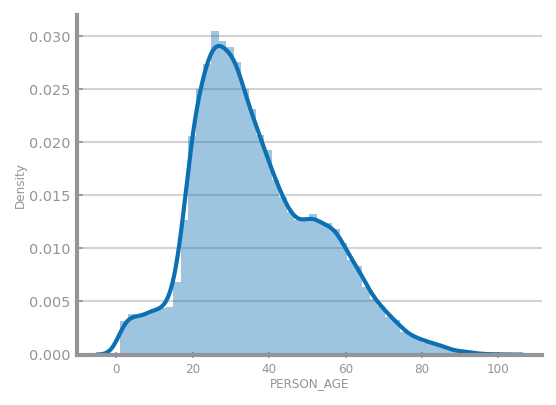

In [45]:
# Distribution of records per value
ages_list = data['PERSON_AGE'].dropna().values
ages_list_filter1 = ages_list[ages_list<110]
ages_list_filter2 = ages_list_filter1[ages_list_filter1>0]
distplot(ages_list_filter2, norm_hist=True, axlabel='PERSON_AGE')
plt.savefig('dataset_1/profiling/distribution/histograms_trend_numeric_ds1.png')
plt.show()

Norm 36.91832656052228 16.43822949188755
Exp 2.0 34.91832656052228
LogNorm 4.1459362286389165 1.9999999444304475 1.6218125265115142


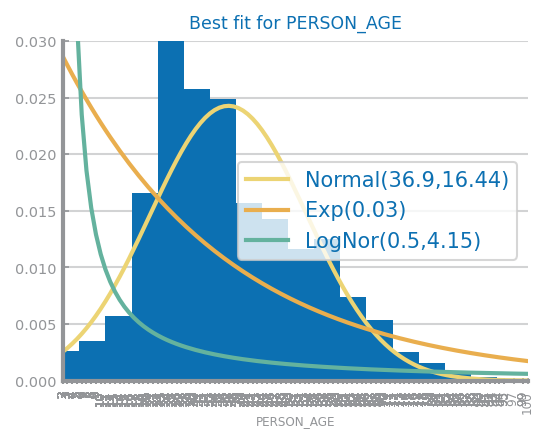

In [46]:
ax_dist = plt.axes()
ax_dist.locator_params(nbins=10, axis='x')
ser = data['PERSON_AGE'].dropna()
ser = ser.where(ser>0).where(ser<110)

z=list(data['PERSON_AGE'])
sr=data['PERSON_AGE']
sr[(sr<100) | (sr >=1)]
pd.Series(list(sr))

def compute_known_distributions(x_values: list) -> dict:
    distributions = dict()
    # Gaussian
    mean, sigma = norm.fit(x_values)
    distributions['Normal(%.1f,%.2f)'%(mean,sigma)] = norm.pdf(x_values, mean, sigma)
    print( "Norm", mean, sigma)
    # Exponential
    loc, scale = expon.fit(x_values)
    print( "Exp", loc, scale)
    distributions['Exp(%.2f)'%(1/scale)] = expon.pdf(x_values, loc, scale)
    # LogNorm
    sigma, loc, scale = lognorm.fit(x_values)
    print( "LogNorm", sigma, loc, scale)
    distributions['LogNor(%.1f,%.2f)'%(log(scale),sigma)] = lognorm.pdf(x_values, sigma, loc, scale)
    return distributions

def histogram_with_distributions(ax: Axes, series: pd.Series, var: str):
    values = series.sort_values().values
    ax.hist(values,20,density=True, range=(0,110))
    plt.xticks(rotation=90)
    distributions = compute_known_distributions(values)
    ax.set_ylim(0,0.03)
    multiple_line_chart(values, distributions, ax=ax, title='Best fit for %s'%var, xlabel=var, ylabel='')
    
histogram_with_distributions(ax_dist,sr.where(sr>1).where(sr<110).dropna(), 'PERSON_AGE')
plt.savefig('dataset_1/profiling/distribution/histogram_numeric_distribution_ds1.png')
plt.show()

Symbolic variables

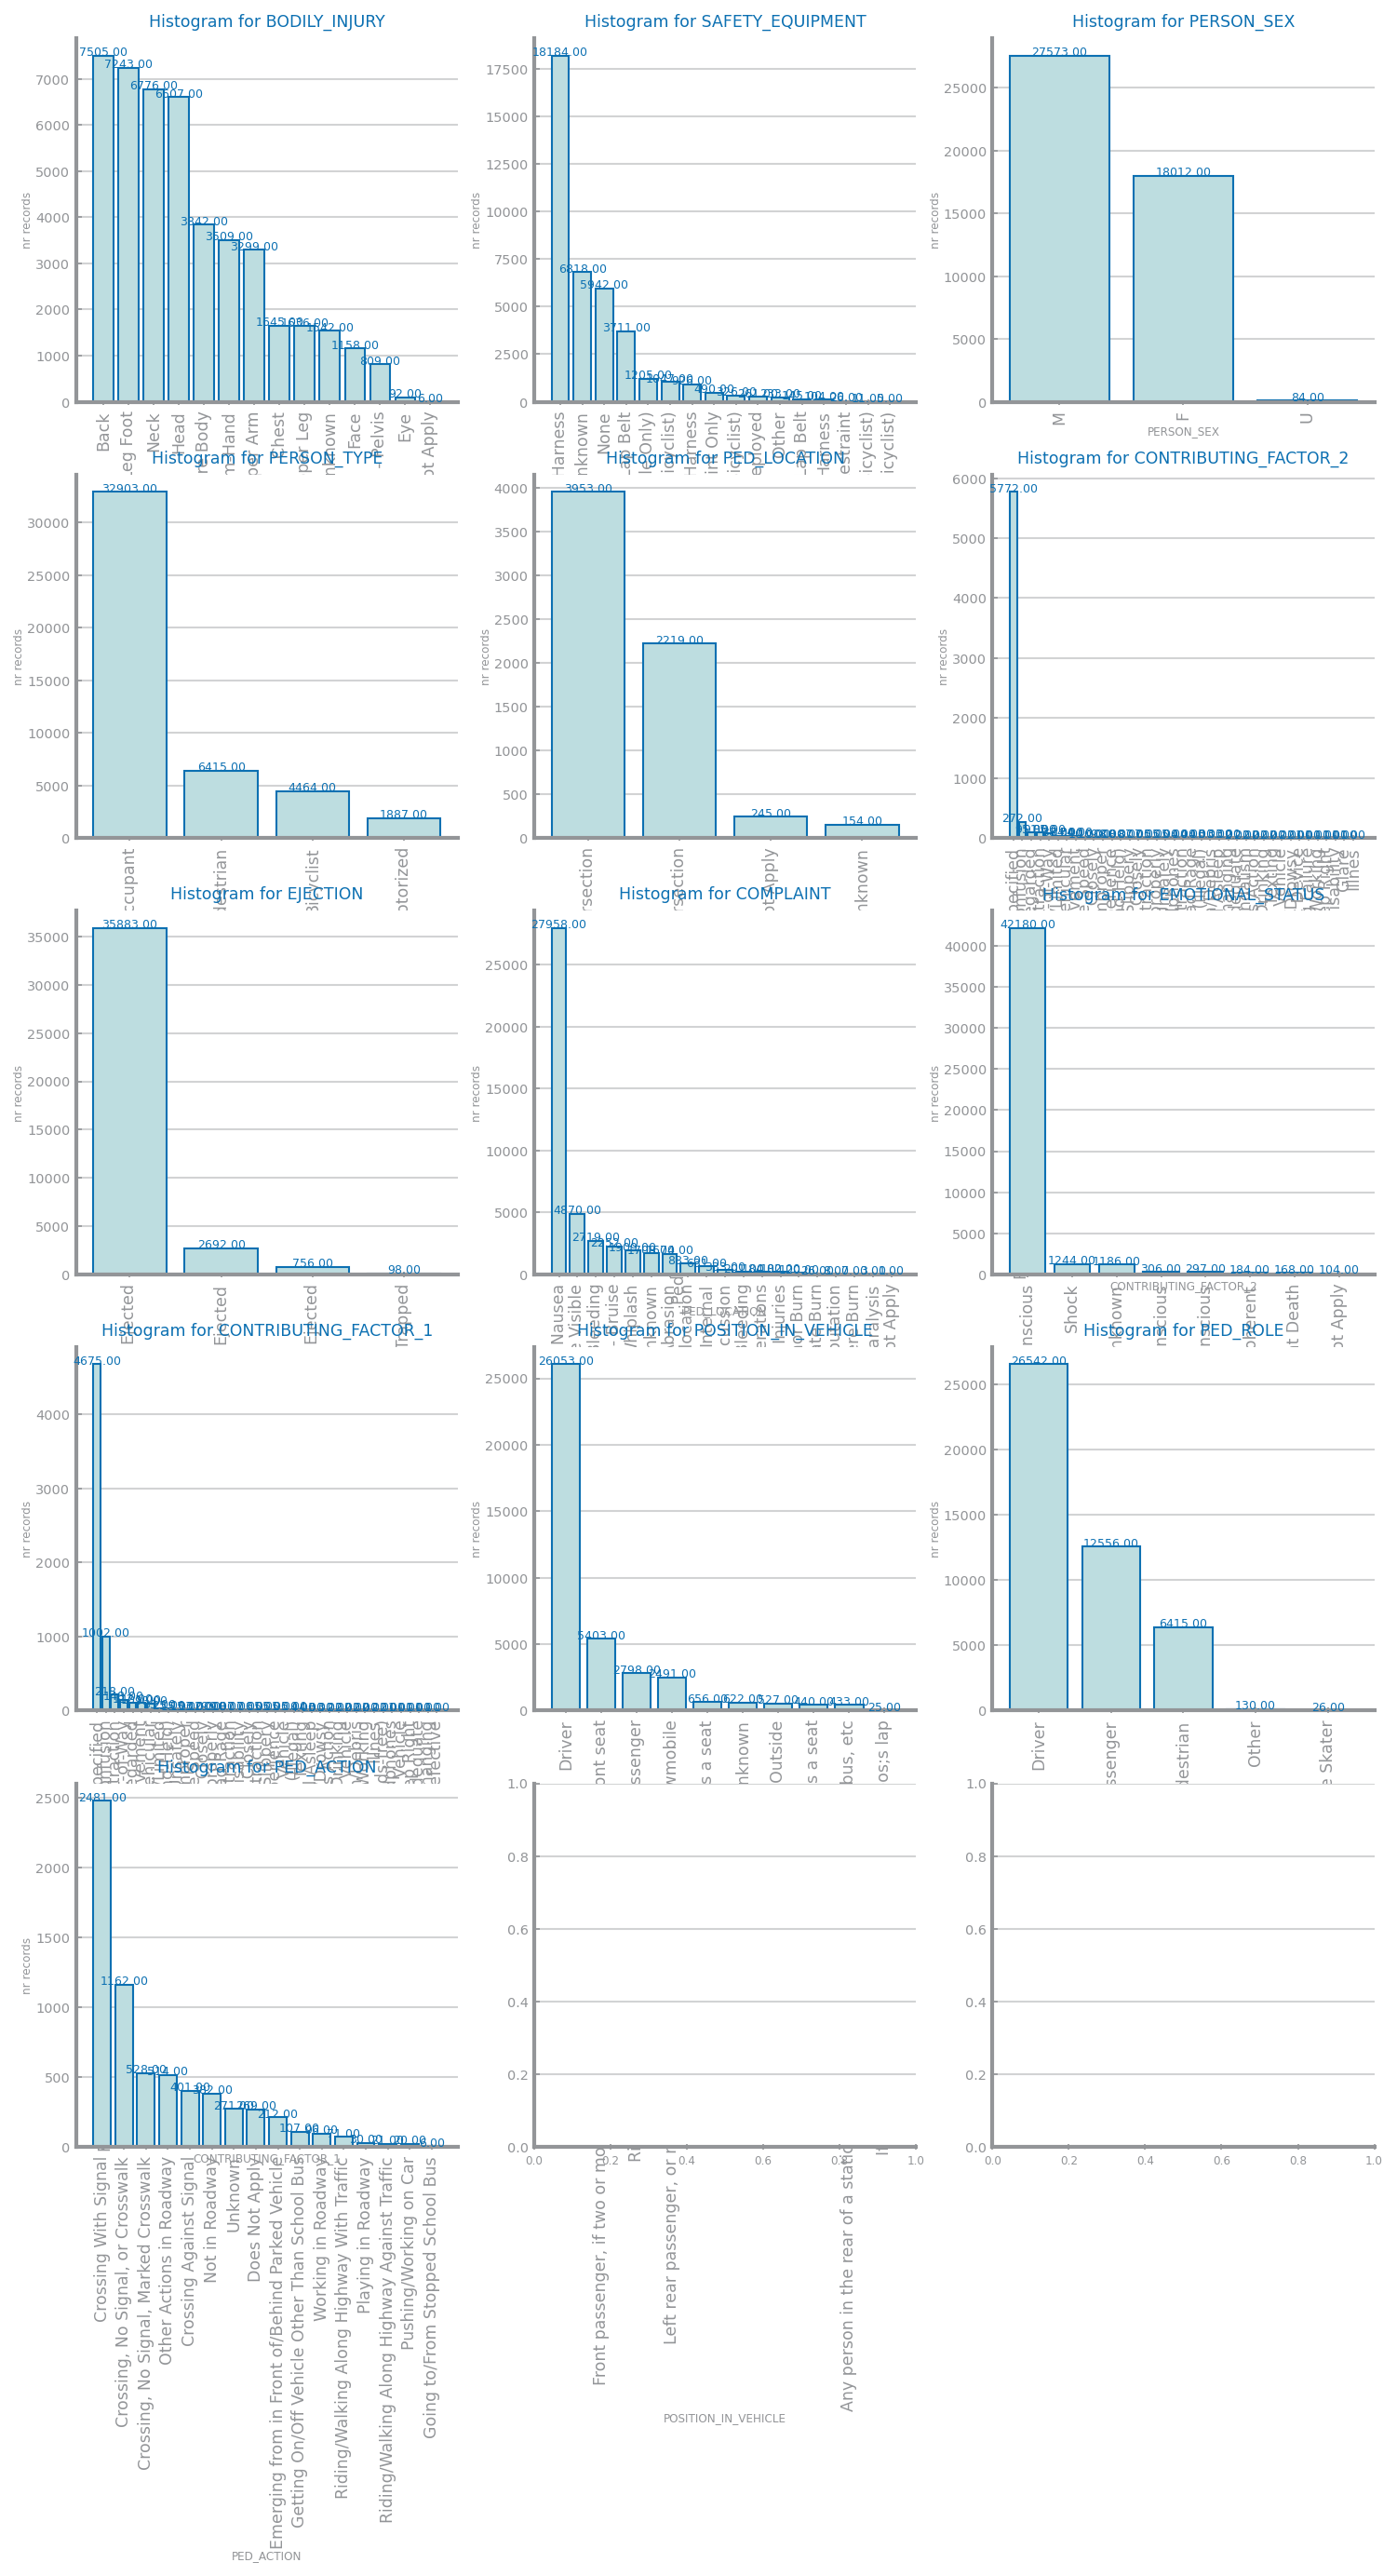

In [47]:
symbolic_vars = ['BODILY_INJURY','SAFETY_EQUIPMENT','PERSON_SEX','PERSON_TYPE','PED_LOCATION','CONTRIBUTING_FACTOR_2','EJECTION','COMPLAINT','EMOTIONAL_STATUS','CONTRIBUTING_FACTOR_1','POSITION_IN_VEHICLE','PED_ROLE','PED_ACTION']
if [] == symbolic_vars:
    raise ValueError('There are no symbolic variables.')

rows, cols = choose_grid(len(symbolic_vars))
fig, axs = plt.subplots(rows, cols, figsize=(cols*HEIGHT, rows*HEIGHT), squeeze=False)
i, j = 0, 0
for n in range(len(symbolic_vars)):
    counts = data[symbolic_vars[n]].value_counts()
    bar_chart(counts.index.to_list(), counts.values, ax=axs[i, j], title='Histogram for %s'%symbolic_vars[n], xlabel=symbolic_vars[n], ylabel='nr records', percentage=False, rotation=True)
    i, j = (i + 1, 0) if (n+1) % cols == 0 else (i, j + 1)
plt.savefig('dataset_1/profiling/distribution/histograms_symbolic_ds1.png')
plt.show()

Class distribution

dict_values([45416, 253])


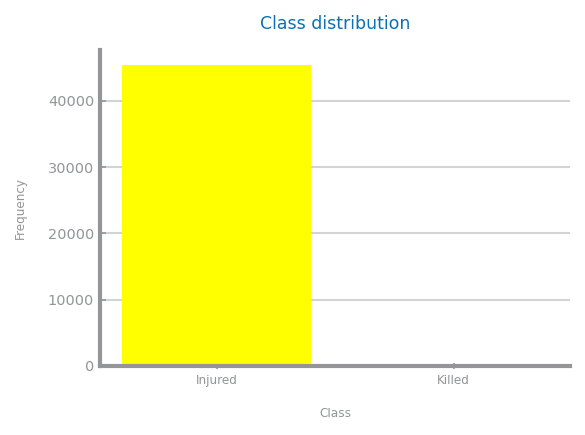

In [48]:
classes = data.PERSON_INJURY.value_counts().to_dict()
print(classes.values())

plt.title('Class distribution', pad=10.0)
plt.ylabel('Frequency', labelpad=10.0)
plt.xlabel('Class', labelpad=10.0)
plt.bar(classes.keys(), classes.values(), color=['yellow', 'red'])
plt.tight_layout()
plt.savefig("dataset_1/profiling/distribution/class_distribuition_ds1.png")

# Data Sparsity

Scatter plots for pairs

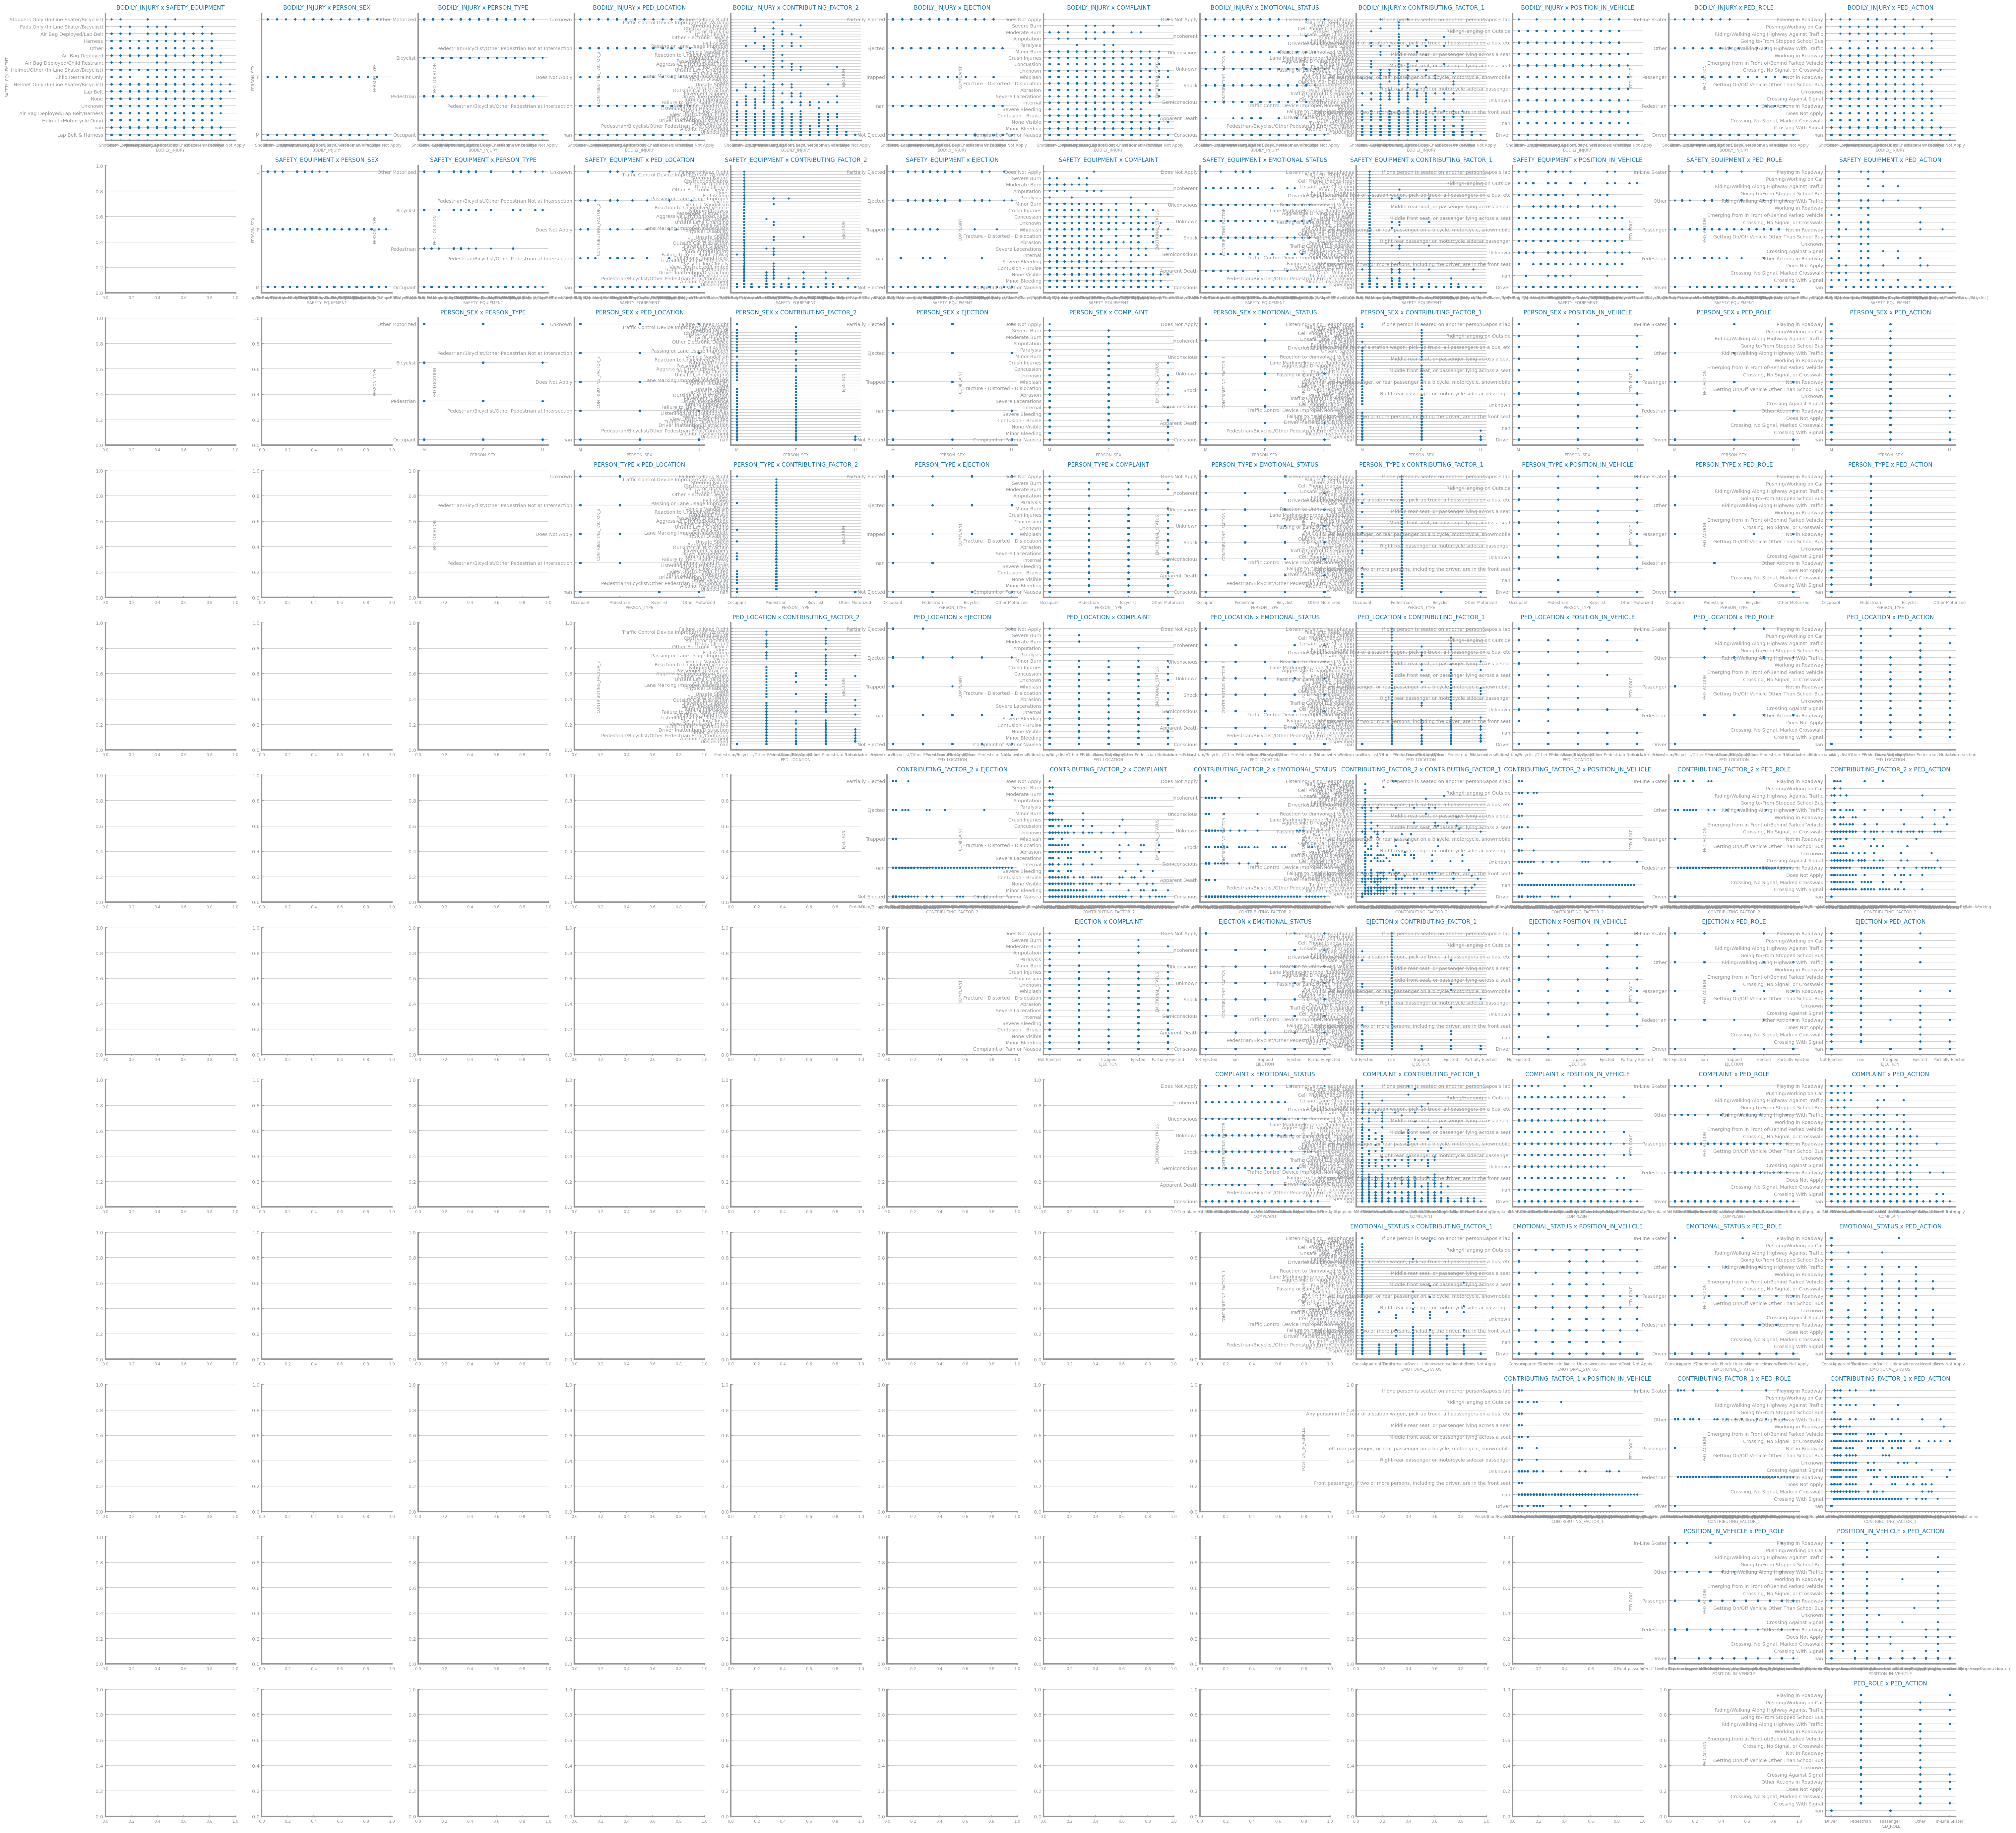

In [49]:
pd.plotting.register_matplotlib_converters()
if [] == symbolic_vars:
    raise ValueError('There are no symbolic variables.')
rows, cols = len(symbolic_vars)-1, len(symbolic_vars)-1
fig, axs = plt.subplots(rows, cols, figsize=(cols*HEIGHT, rows*HEIGHT), squeeze=False)
for i in range(len(symbolic_vars)):
    var1 = symbolic_vars[i]
    for j in range(i+1, len(symbolic_vars)):
        var2 = symbolic_vars[j]
        axs[i, j-1].set_title("%s x %s"%(var1,var2))
        axs[i, j-1].set_xlabel(var1)
        axs[i, j-1].set_ylabel(var2)         
        # axs[i, j-1].scatter(data[var1].apply(str), data[var2].apply(str))
        axs[i, j-1].scatter(data[var1].astype(str), data[var2].astype(str))
plt.savefig('dataset_1/profiling/sparsity/sparsity_study_symbolic_ds1.png')
plt.show()

Scatter plots with class

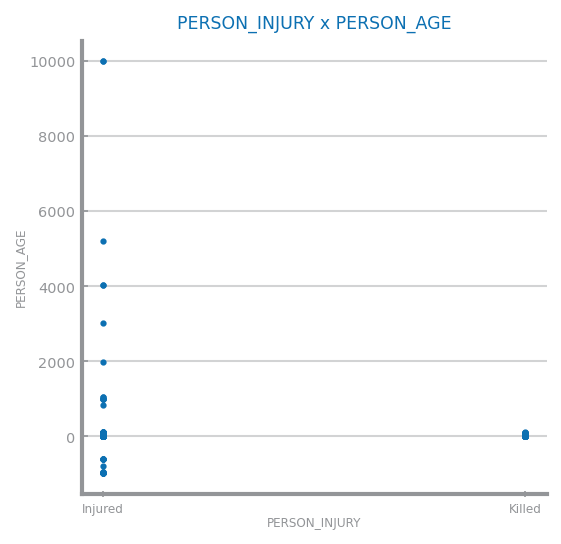

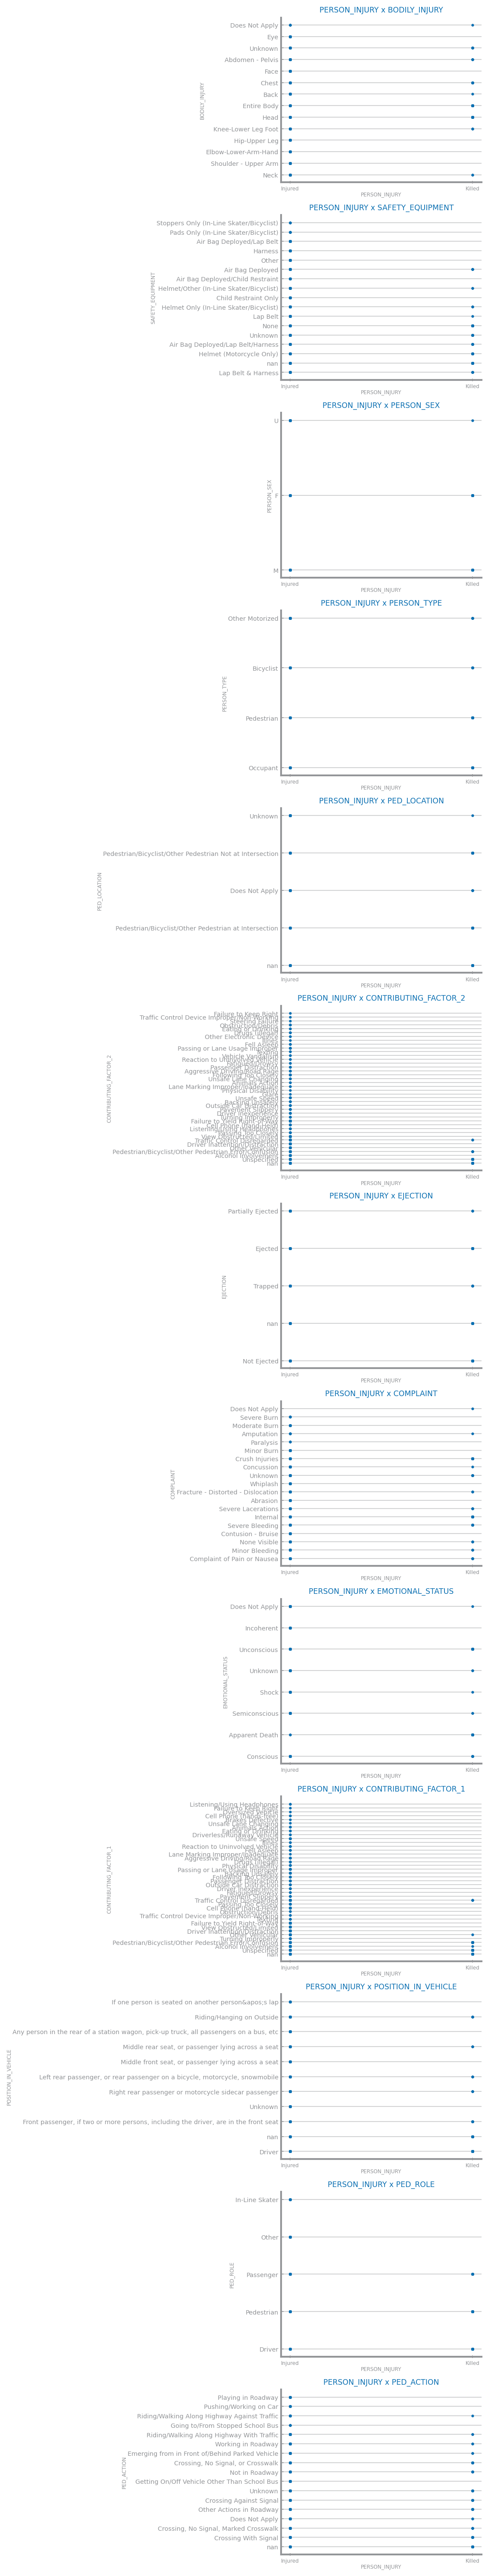

In [50]:
vars = list(data.columns)[:-1]
target = 'PERSON_INJURY'

# Numeric Variables
if [] == numeric_vars:
    raise ValueError('There are no numeric variables.')
rows, cols = len(numeric_vars), 1
fig, axs = plt.subplots(rows, cols, figsize=(cols*HEIGHT, rows*HEIGHT), squeeze=False)
for i in range(len(numeric_vars)):
    var = numeric_vars[i]
    axs[i, 0].set_title("%s x %s"%(target,var))
    axs[i, 0].set_xlabel(target)
    axs[i, 0].set_ylabel(var)
    axs[i, 0].scatter(data[target], data[var])
plt.savefig('dataset_1/profiling/sparsity/sparsity_class_numeric_ds1.png')

# Symbolic variables
if [] == symbolic_vars:
    raise ValueError('There are no symbolic variables.')
rows, cols = len(symbolic_vars), 1
fig, axs = plt.subplots(rows, cols, figsize=(cols*HEIGHT, rows*HEIGHT), squeeze=False)
for i in range(len(symbolic_vars)):
    var = symbolic_vars[i]
    axs[i, 0].set_title("%s x %s"%(target,var))
    axs[i, 0].set_xlabel(target)
    axs[i, 0].set_ylabel(var)
    # axs[i, 0].scatter(data[target], data[var].apply(str))
    axs[i, 0].scatter(data[target].astype(str), data[var].astype(str))
plt.savefig('dataset_1/profiling/sparsity/sparsity_class_symbolic_ds1.png')

# Correlation

Correlation between all pairs

                       BODILY_INJURY  SAFETY_EQUIPMENT  PERSON_SEX  \
BODILY_INJURY               1.000000          0.034876    0.012431   
SAFETY_EQUIPMENT            0.034876          1.000000   -0.107308   
PERSON_SEX                  0.012431         -0.107308    1.000000   
PERSON_TYPE                -0.045187          0.198751   -0.159229   
PED_LOCATION               -0.017508         -0.341161    0.039330   
CONTRIBUTING_FACTOR_2      -0.009071         -0.175193    0.017713   
EJECTION                    0.003855          0.386079   -0.152075   
COMPLAINT                   0.096994          0.076650   -0.035942   
EMOTIONAL_STATUS            0.106042          0.035328   -0.005046   
CONTRIBUTING_FACTOR_1      -0.016385         -0.189645    0.024343   
POSITION_IN_VEHICLE         0.053320          0.218471    0.124593   
PED_ROLE                    0.045640         -0.099473    0.280739   
PED_ACTION                 -0.011954         -0.295333    0.015521   

                   

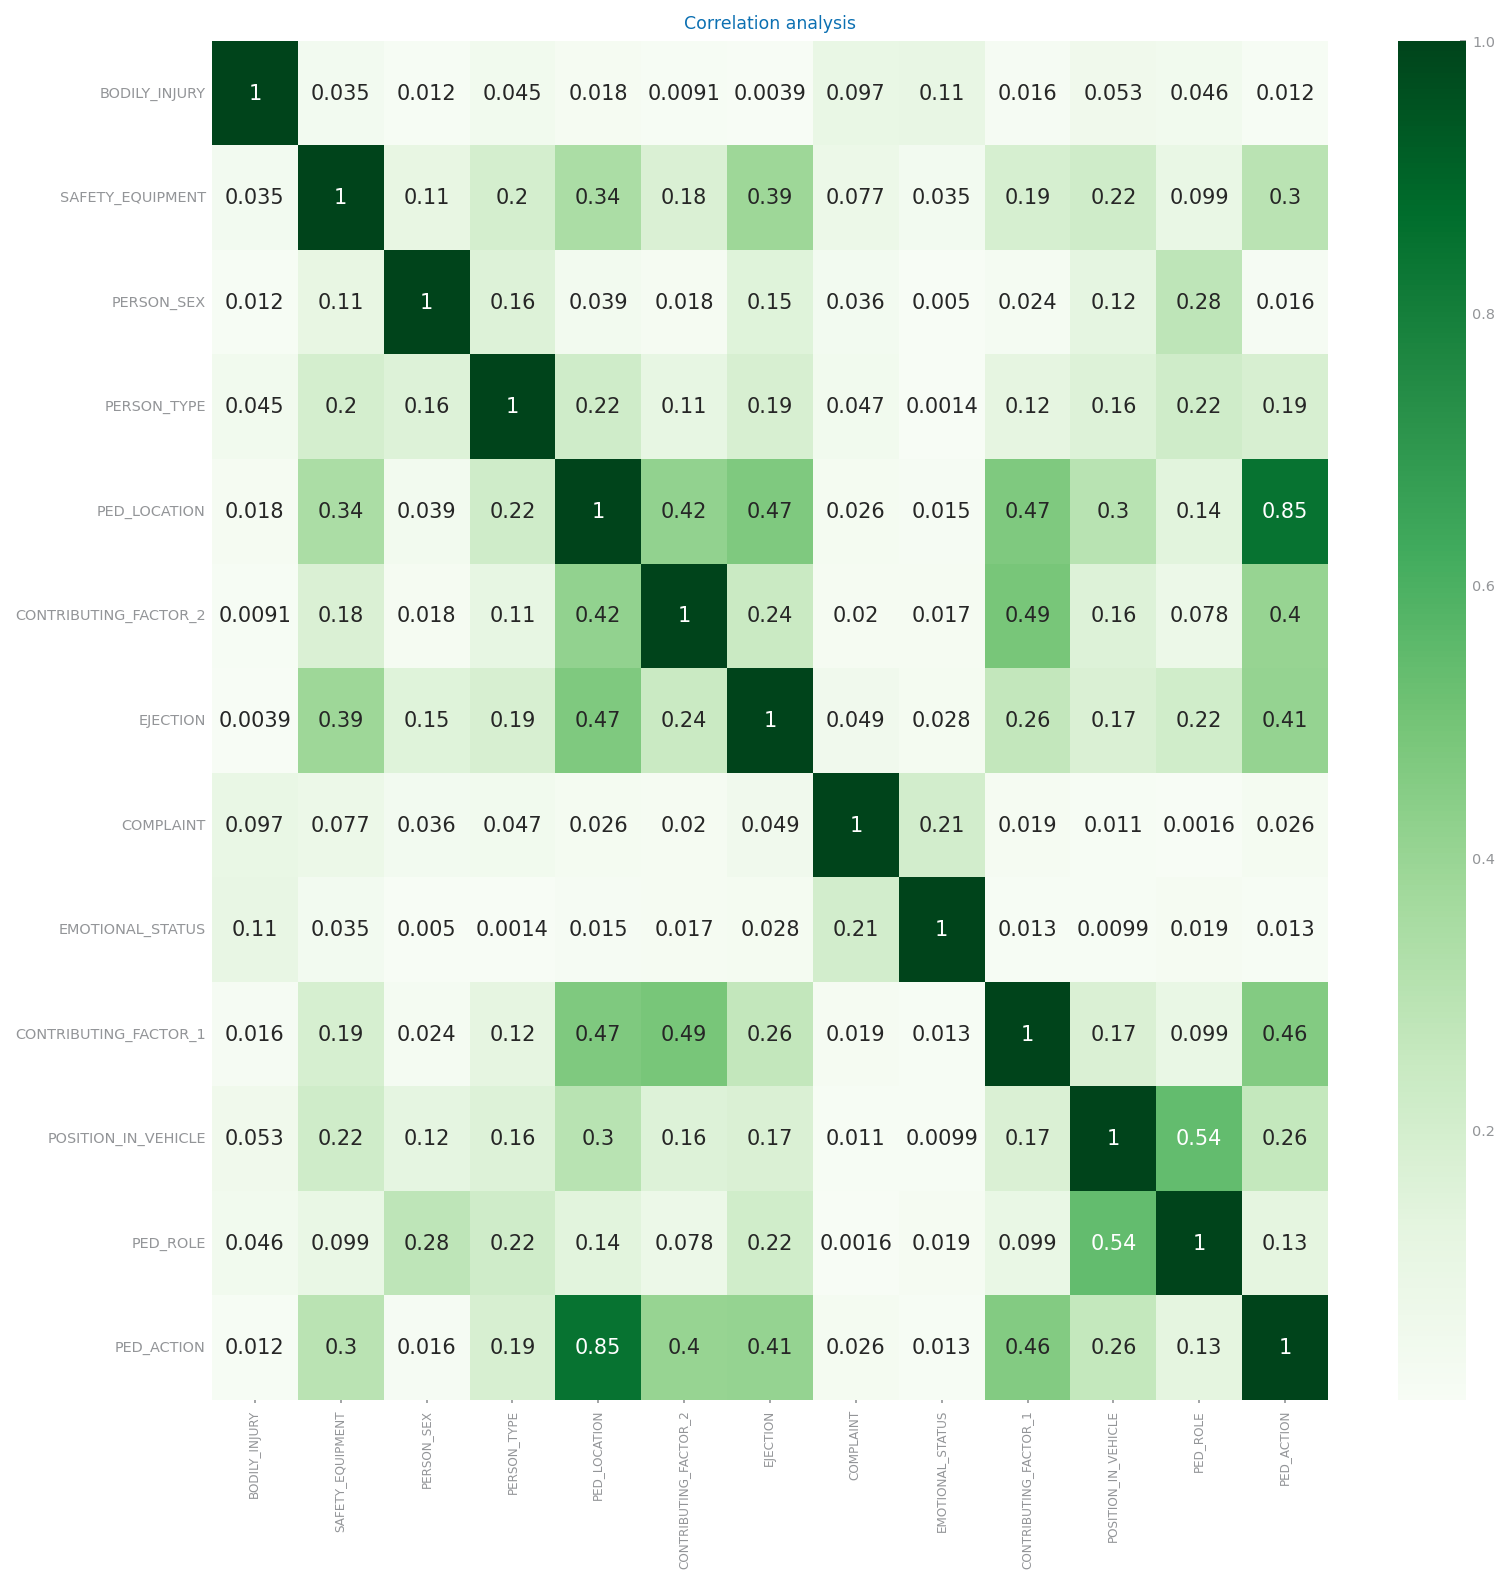

In [51]:
# Symbolic variables
just_symbolic = data[symbolic_vars].copy()
corr_mtx = just_symbolic.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)
print(corr_mtx)
fig = plt.figure(figsize=[12, 12])

heatmap(abs(corr_mtx), xticklabels=corr_mtx.columns, yticklabels=corr_mtx.columns, annot=True, cmap='Greens')
plt.title('Correlation analysis')
plt.savefig('dataset_1/profiling/correlation/correlation_analysis_symbolic_ds1.png')
plt.show()

Correlation with class

In [52]:
data_aux = pd.read_csv(filename, na_values='na')
for i in range(len(data_aux.PERSON_INJURY)):
    if data_aux.PERSON_INJURY[i] == 'Injured':
        data_aux.PERSON_INJURY[i] = 0
    else:
        data_aux.PERSON_INJURY[i] = 1
data_aux.PERSON_INJURY = data_aux.PERSON_INJURY.astype(str).astype('int64')

               PERSON_AGE  PERSON_INJURY
PERSON_AGE       1.000000       0.008022
PERSON_INJURY    0.008022       1.000000
                       BODILY_INJURY  SAFETY_EQUIPMENT  PERSON_SEX  \
BODILY_INJURY               1.000000          0.034876    0.012431   
SAFETY_EQUIPMENT            0.034876          1.000000   -0.107308   
PERSON_SEX                  0.012431         -0.107308    1.000000   
PERSON_TYPE                -0.045187          0.198751   -0.159229   
PED_LOCATION               -0.017508         -0.341161    0.039330   
CONTRIBUTING_FACTOR_2      -0.009071         -0.175193    0.017713   
EJECTION                    0.003855          0.386079   -0.152075   
COMPLAINT                   0.096994          0.076650   -0.035942   
EMOTIONAL_STATUS            0.106042          0.035328   -0.005046   
CONTRIBUTING_FACTOR_1      -0.016385         -0.189645    0.024343   
POSITION_IN_VEHICLE         0.053320          0.218471    0.124593   
PED_ROLE                    0.045640 

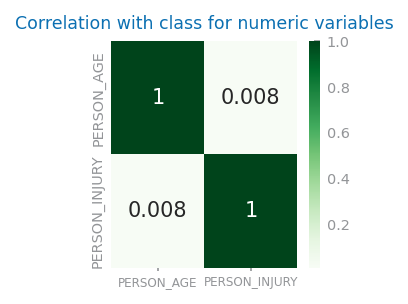

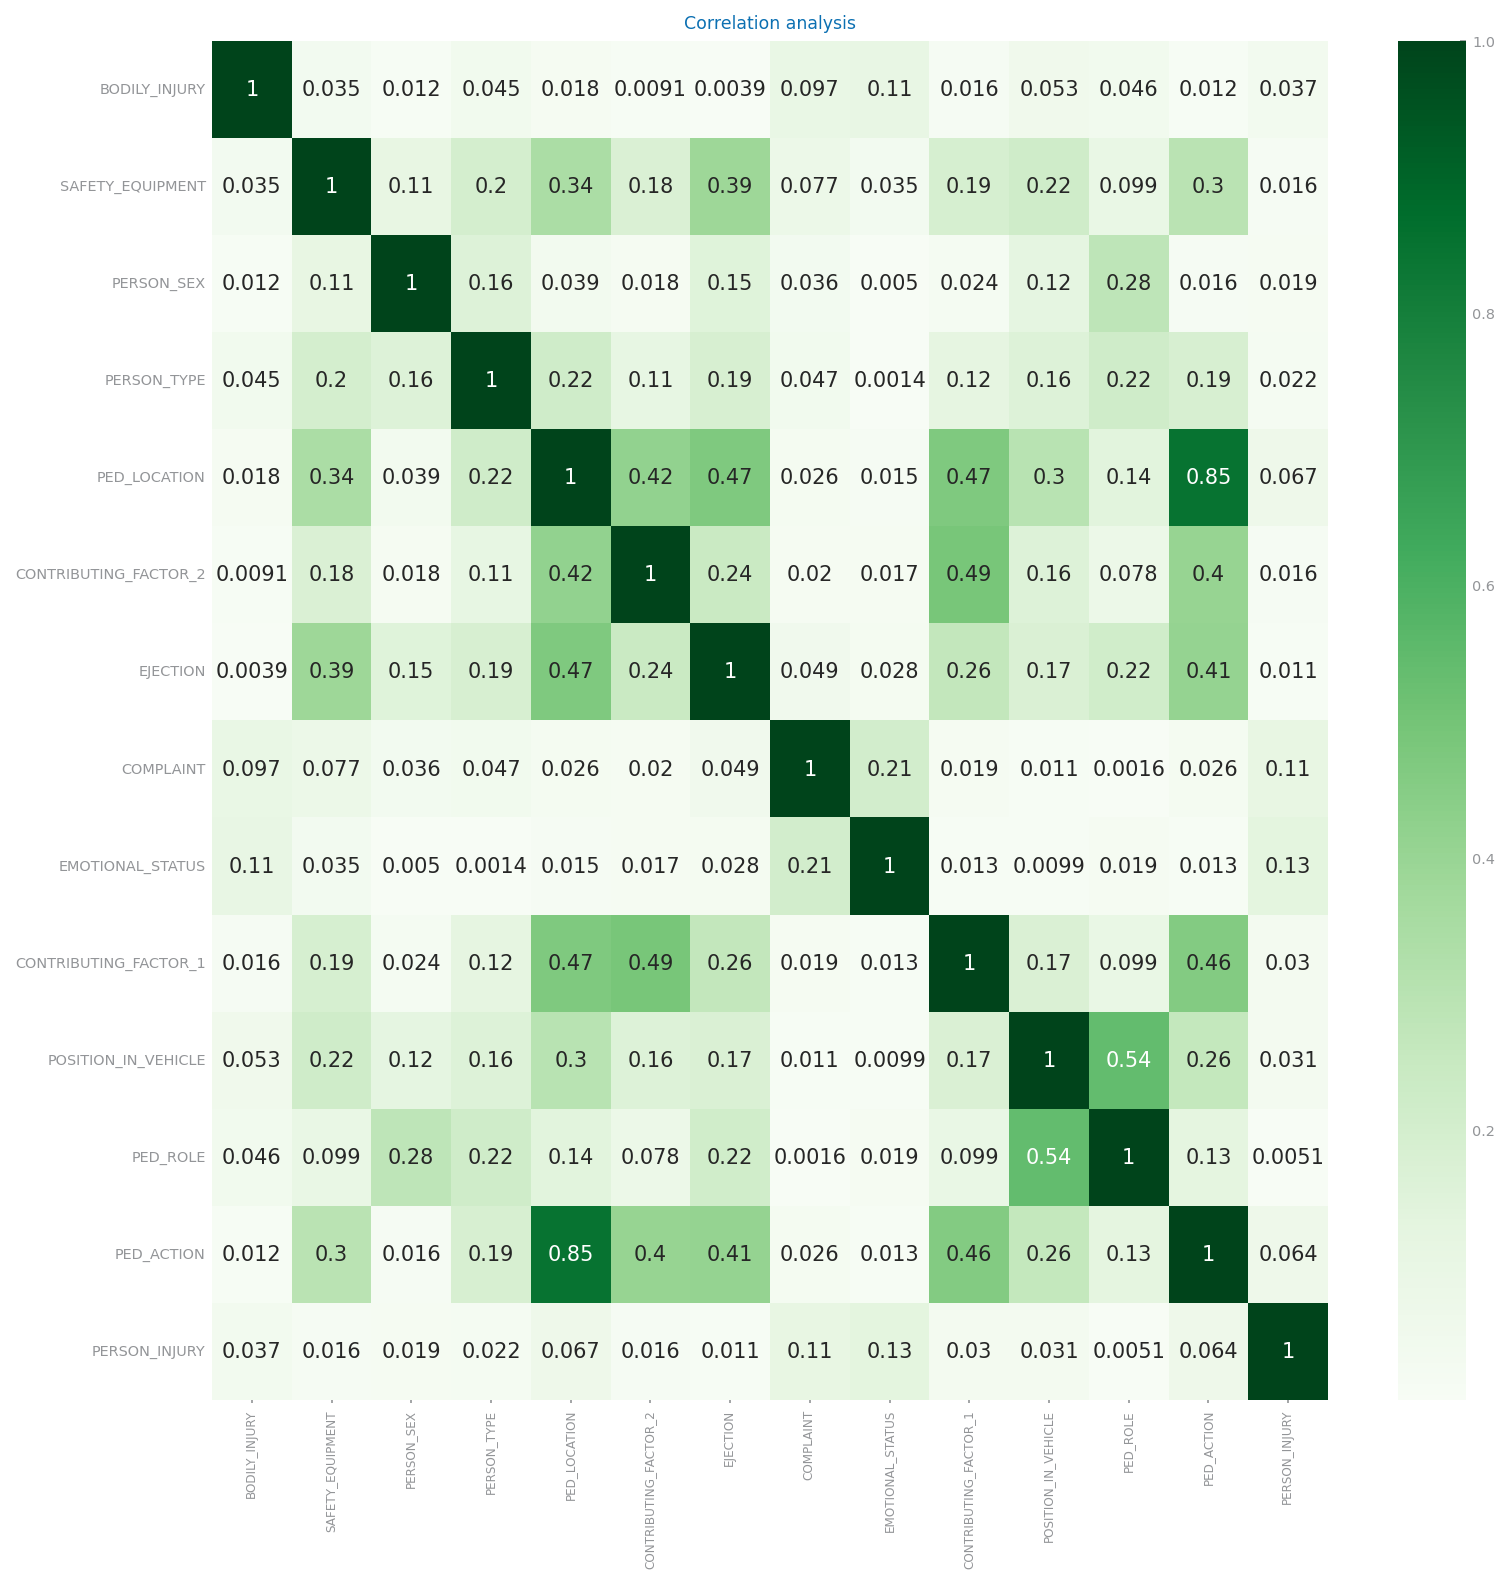

In [53]:
# Numeric variables
data_aux_numeric = data_aux[['PERSON_AGE', 'PERSON_INJURY']]
corr_mtx = pd.DataFrame(abs(data_aux_numeric.corr()))
print(corr_mtx)

fig = plt.figure(figsize=[2, 2])

heatmap(abs(corr_mtx), xticklabels=corr_mtx.columns, yticklabels=corr_mtx.index.values, annot=True, cmap='Greens')
plt.title('Correlation with class for numeric variables')
plt.savefig('dataset_1/profiling/correlation/correlation_with_class_numeric_ds1.png')

# Symbolic variables
data_aux_symbolic = data_aux[['BODILY_INJURY','SAFETY_EQUIPMENT','PERSON_SEX','PERSON_TYPE','PED_LOCATION','CONTRIBUTING_FACTOR_2','EJECTION','COMPLAINT','EMOTIONAL_STATUS','CONTRIBUTING_FACTOR_1','POSITION_IN_VEHICLE','PED_ROLE','PED_ACTION','PERSON_INJURY']]
corr_mtx = data_aux_symbolic.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)
print(corr_mtx)
fig = plt.figure(figsize=[12, 12])

heatmap(abs(corr_mtx), xticklabels=corr_mtx.columns, yticklabels=corr_mtx.columns, annot=True, cmap='Greens')
plt.title('Correlation analysis')
plt.savefig('dataset_1/profiling/correlation/correlaton_with_class_symbolic_ds1.png')
plt.show()